# UUDBを用いた心的状態の推定

- HuggingFace Transformers を利用します．
- モデルは Wav2Vec2-base を基本とします．

事前に [make_dataset.ipynb](make_dataset.ipynb) を実行してデータセットを作成してください．


In [10]:
# 1. データセットの準備
from datasets import load_from_disk
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import torch
import torch.nn as nn
from safetensors.torch import load_file
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

データセットを読み込み，前処理をします．

In [11]:
# データセットの読み込み
dataset = load_from_disk("./uudb_dataset")

# プロセッサーの準備
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# 1つのオーディオサンプルから特徴量を抽出
def preprocess_function(examples):
    audio = examples["audio"]["array"]
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
    return {"input_values": inputs["input_values"].squeeze().tolist()}

# データセットに前処理を適用
processed_dataset = dataset.map(preprocess_function, remove_columns=["audio"])

/home/fujie/.conda/envs/py311/lib/python3.11/site-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


wav2vec2モデルのヘッド（最終層）に，心的状態を推定するためネットワークを追加したカスタムモデルを定義します．

In [12]:
# 2. カスタムモデルの定義
class Wav2Vec2ForMultitaskRegression(nn.Module):
    def __init__(self, wav2vec_model_name="facebook/wav2vec2-base"):
        super(Wav2Vec2ForMultitaskRegression, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained(wav2vec_model_name)
        self.attention = nn.Linear(self.wav2vec.config.hidden_size, 1) # 1次元出力
        self.regression_head = nn.Linear(self.wav2vec.config.hidden_size, 6)  # 6次元出力
    
    def forward(self, input_values, labels=None):
        outputs = self.wav2vec(input_values).last_hidden_state # (batch_size, seq_len, hidden_size)
        # # mean pooling: 各時間ステップの特徴量の平均を取る
        # pooled_output = outputs.mean(dim=1)
        
        # attention pooling: 各時間ステップの重み付き和を取る
        attention_weights = torch.softmax(self.attention(outputs), dim=1) # (batch_size, seq_len, 1)
        pooled_output = torch.sum(outputs * attention_weights, dim=1) # (batch_size, hidden_size)

        logits = self.regression_head(pooled_output) # (batch_size, 6)

        if labels is not None:
            loss = nn.MSELoss()(logits, labels)
            return loss, logits
        return logits

学習時に必要となるデータ加工を行う `DataCollator` を定義します．

In [13]:
def data_collator(features):
    # input_valuesがリスト形式であることを確認
    input_values = [f["input_values"] for f in features]

    # パディングを適用して、すべての入力が同じ長さになるようにする
    batch = processor.pad({"input_values": input_values}, padding=True, return_tensors="pt")

    # print(batch)
    # print(features[0].keys())

    # ターゲット値もバッチとしてまとめる
    # "pleasantness", "arousal", "dominance", "credibility", "interest", "positivity"
    batch["labels"] = torch.tensor([[f["pleasantness"], f["arousal"], 
                                    f["dominance"], f["credibility"], 
                                    f["interest"], f["positivity"]] for f in features])
    return batch

学習を実行します．

In [14]:
# 学習を実行する場合は True に設定してください．
do_train = False

In [15]:
# 4. 損失関数の設定と学習

# 学習の設定
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    num_train_epochs=100,
    learning_rate=2e-5,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    save_strategy="epoch",
)

# カスタムモデルのインスタンスを作成
model = Wav2Vec2ForMultitaskRegression()

if do_train is True:
    # Trainerのセットアップ
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=processed_dataset["train"],
        eval_dataset=processed_dataset["validation"],
        data_collator=data_collator,
        compute_metrics=lambda p: {"mse": ((p.predictions - p.label_ids) ** 2).mean().item()},
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # 学習の実行
    trainer.train()

/home/fujie/.conda/envs/py311/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/fujie/.conda/envs/py311/lib/python3.11/site-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to 

学習を飛ばした場合，下記のセルを実行して以前の学習結果のモデルを読み込みます．

`safetensors_path`の，`checkpoint-XXXX`のXXXXは，状況に応じて変更してください．

In [16]:
safetensors_path = "./results/checkpoint-4587/model.safetensors"
# safetensorsからmodelのパラメタを読み込む
state_dict = load_file(safetensors_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

予測の実施．

テストデータに対して，モデルで予測を行い結果を `result_df` にまとめます．

In [18]:
def predict(model, processor, audio):
    input_values = processor(audio, sampling_rate=16000, return_tensors="pt").input_values
    with torch.no_grad():
        pred = model(input_values.to('cuda')).squeeze()
    # "pleasantness", "arousal", "dominance", "credibility", "interest", "positivity"
    return {"pleasantness": pred[0].item(), "arousal": pred[1].item(), 
            "dominance": pred[2].item(), "credibility": pred[3].item(), 
            "interest": pred[4].item(), "positivity": pred[5].item()}

preds = []
for data in dataset["test"]:
    preds.append(predict(model, processor, data["audio"]["array"]))

pred_df = pd.DataFrame(preds)
true_df = pd.DataFrame(dataset["test"]).drop(columns=["audio"])

# indexを無視し，pred_dfのcolumn名それぞれにpred_をつけ，true_dfの横にpred_dfをつなげる
result_df = pd.concat([true_df, pred_df.add_prefix("pred_")], axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [192]:
result_df

,session,channel,utterance_number,speaker,pleasantness,arousal,dominance,credibility,interest,positivity,pred_pleasantness,pred_arousal,pred_dominance,pred_credibility,pred_interest,pred_positivity
0,C052,L,1,FMS,2.67,3.00,4.67,2.33,5.00,2.33,3.191644,2.569473,3.498031,3.354503,4.270540,3.379714
1,C052,R,1,FJK,2.00,2.67,3.67,2.00,4.67,2.33,3.169920,3.758402,4.132307,3.179973,4.800211,3.286736
2,C052,R,2,FJK,3.33,3.67,5.67,4.33,5.00,4.67,3.696247,4.137963,4.623348,4.376753,4.536357,4.601446
3,C052,L,2,FMS,3.33,4.67,3.33,4.67,4.00,4.33,3.793887,3.819668,2.694152,4.278625,4.435909,4.408888
4,C052,L,3,FMS,4.00,4.00,3.00,5.00,4.67,5.33,3.580613,3.090152,2.892590,3.867498,3.811166,3.991129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,C053,R,30,FJK,3.33,3.00,4.00,3.67,4.00,3.67,3.647405,3.557457,4.595594,4.319932,4.426310,4.460724
165,C053,L,31,FMS,4.67,4.33,4.67,4.67,4.33,4.67,3.914863,4.255058,4.915975,4.326647,5.054577,4.425114
166,C053,R,31,FJK,4.33,4.00,3.33,5.00,4.00,5.33,3.698556,3.929810,3.720255,4.083568,4.376451,4.278494
167,C053,L,32,FMS,4.00,4.33,3.67,5.00,4.33,5.00,4.033574,4.577758,4.464326,4.152447,4.735549,4.291636


In [193]:
# 推定結果をプロットするための関数
def plot_regression_results(ax, y_true, y_pred, title, cor):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [0.0, 8.0], [0.0, 8.0], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.1)

    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    # ax.get_xaxis().tick_bottom()
    # ax.get_yaxis().tick_left()
    # ax.spines["left"].set_position(("outward", 10))
    # ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([1.0, 7.0])
    ax.set_ylim([1.0, 7.0])
    ax.set_xlabel("Target")
    ax.set_ylabel("Predicted")
    # extra = plt.Rectangle(
    #     (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    # )
    title = title + " ($r={:.2f}$)".format(cor)
    ax.set_title(title)
    ax.set_aspect('equal')

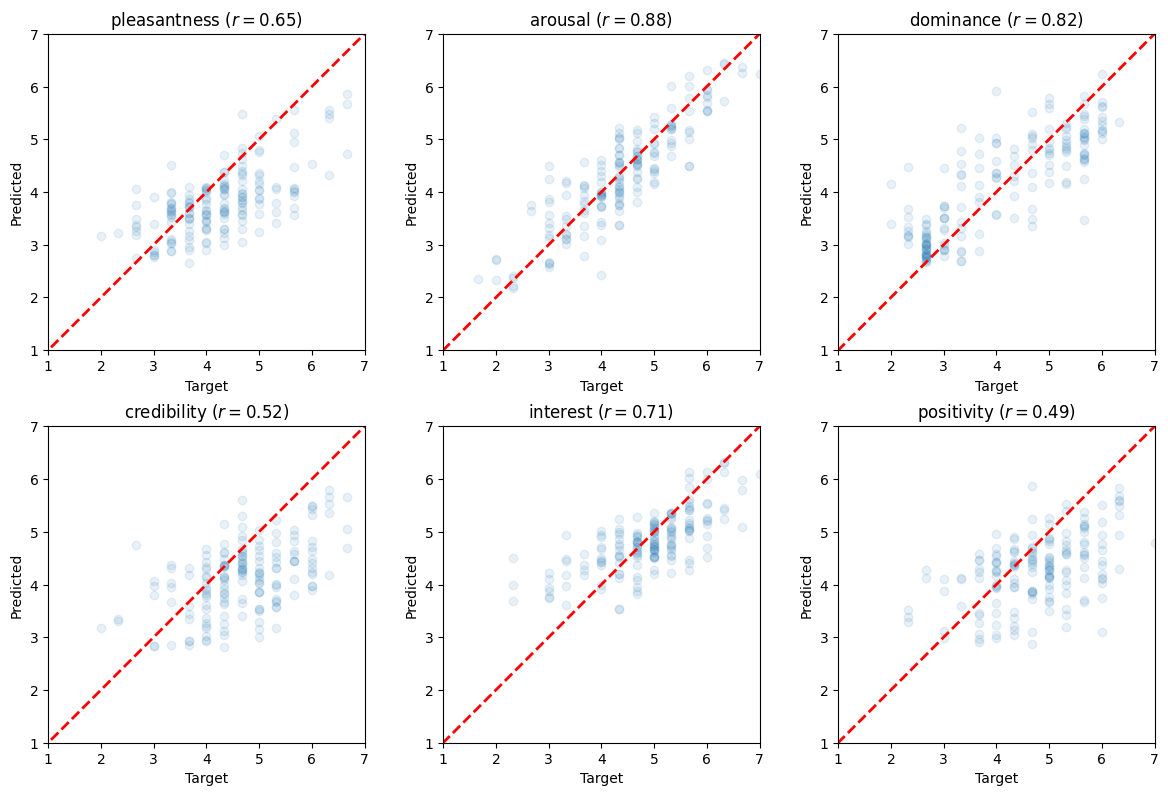

In [197]:
# 推定結果のプロット
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, name in enumerate(["pleasantness", "arousal", "dominance", "credibility", "interest", "positivity"]):
    y_true = result_df[name].values
    y_pred = result_df["pred_" + name].values
    cor = np.corrcoef(y_true, y_pred)[0,1]
    plot_regression_results(axs[i//3, i%3], y_true, y_pred, name, cor)
fig.tight_layout()